In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

In [3]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from scipy.signal.windows import *

In [4]:
torch.cuda.set_device(0)

Kaggle Dog Breed Identification. Get data from https://www.kaggle.com/c/dog-breed-identification

In [5]:
PATH = "data/"
sz = 224
arch = resnext50
bs = 52

In [6]:
label_csv = f'{PATH}y3.csv'
n = len(list(open(label_csv))) - 1 # header is not counted (-1)
val_idxs = get_cv_idxs(n, val_pct=0.2) # random 20% data for validation set

In [7]:
#val_idxs = np.arange(int(n*.8), n)

In [8]:
n

3799

In [9]:
len(val_idxs)

759

In [10]:
# If you haven't downloaded weights.tgz yet, download the file.
#     http://forums.fast.ai/t/error-when-trying-to-use-resnext50/7555
#     http://forums.fast.ai/t/lesson-2-in-class-discussion/7452/222
#!wget -O fastai/weights.tgz http://files.fast.ai/models/weights.tgz

#!tar xvfz fastai/weights.tgz -C fastai

## Initial exploration

In [11]:
!ls {PATH}

0.jpg  43.png			     all.zip			 tmp
0.png  4digit_pin_probabilities.csv  cifar-10-batches-py	 train.zip
1.jpg  4.png			     cifar-10-python.tar.gz	 vidya
1.png  5.png			     frame_extraction_ffmpeg.sh  y2.csv
2.jpg  6.png			     hack_p2.mov		 y3.csv
2.png  7.png			     person.mov			 y.csv
3.jpg  8.png			     sample_submission.csv
3.png  9.png			     screen.mov


In [12]:
label_df = pd.read_csv(label_csv)

In [13]:
label_df.head()

,id,val
0,0,class_10
1,1,class_10
2,2,class_10
3,3,class_10
4,4,class_10


In [14]:
label_df.columns

Index(['id', 'val'], dtype='object')

In [15]:
label_df.pivot_table(index="val", aggfunc=len).sort_values('id', ascending=False)

,id
val,
class_0,462
class_6,417
class_10,396
class_5,387
class_8,373
class_4,331
class_9,328
class_2,311
class_7,305


In [16]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'vidya/person', f'{PATH}y3.csv', # we need to specify where the test set is if you want to submit to Kaggle competitions
                                   val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)

['class_0', 'class_1', 'class_10', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9']
[2 2 2 ... 2 2 2]


In [17]:
fn = PATH + data.trn_ds.fnames[0]; fn

'data/vidya/person/1.jpg'

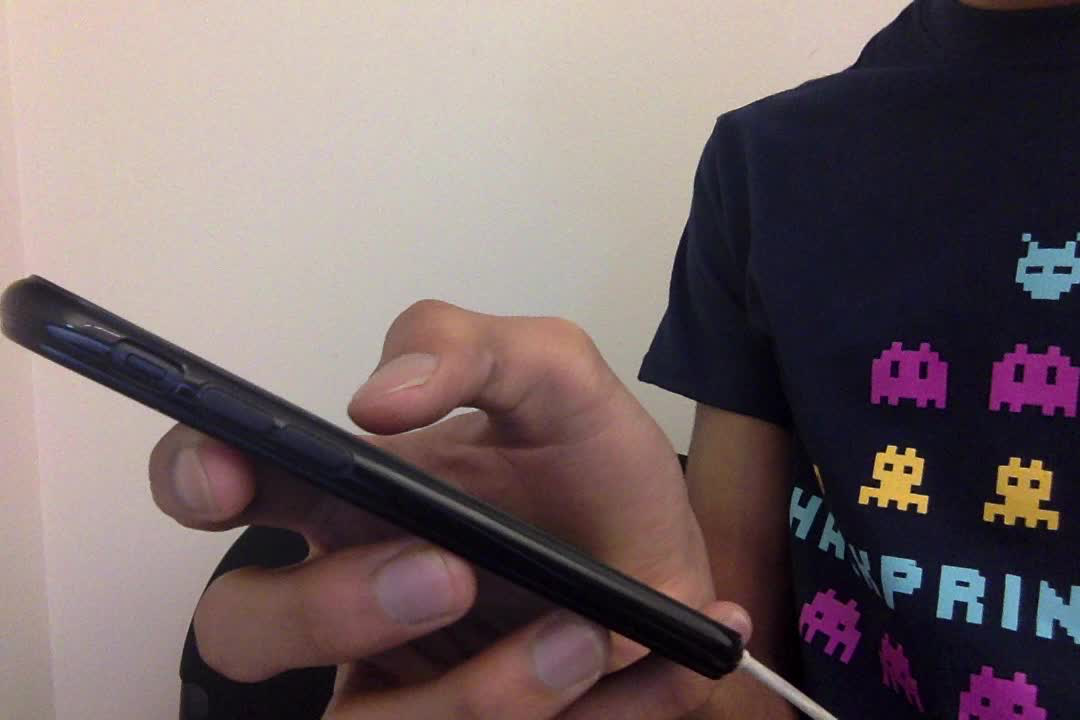

In [18]:
img = PIL.Image.open(fn); img

In [19]:
img.size

(1080, 720)

In [20]:
size_d = {k: PIL.Image.open(PATH + k).size for k in data.trn_ds.fnames}

In [21]:
row_sz, col_sz = list(zip(*size_d.values()))

In [22]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

In [23]:
row_sz[:5]

array([1080, 1080, 1080, 1080, 1080])

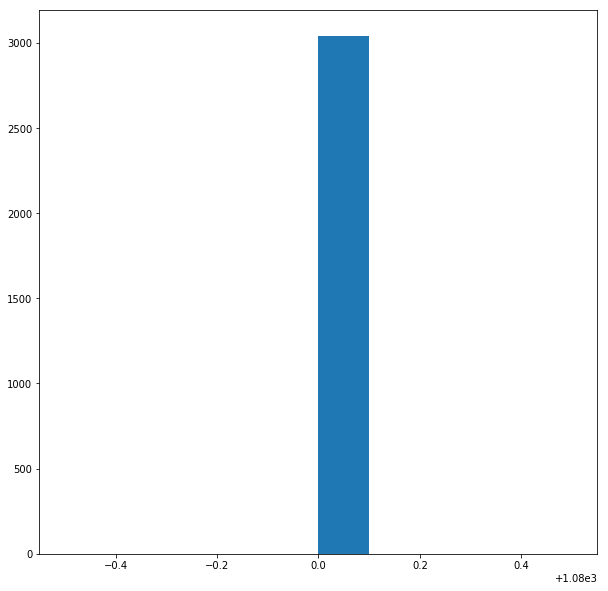

In [24]:
plt.hist(row_sz);

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

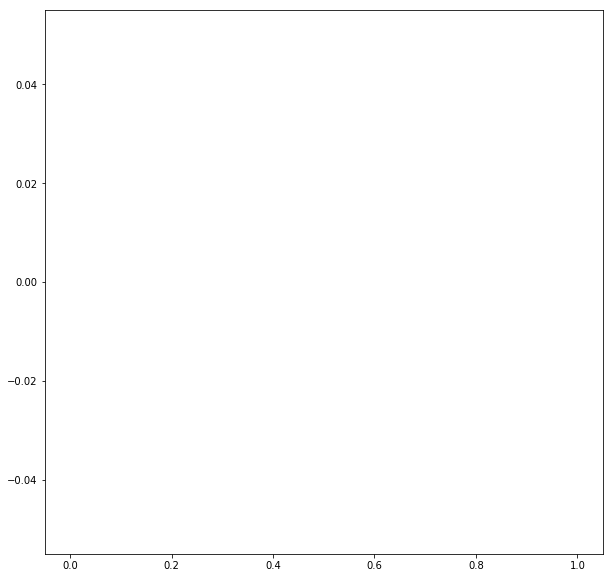

In [25]:
plt.hist(row_sz[row_sz < 1000])

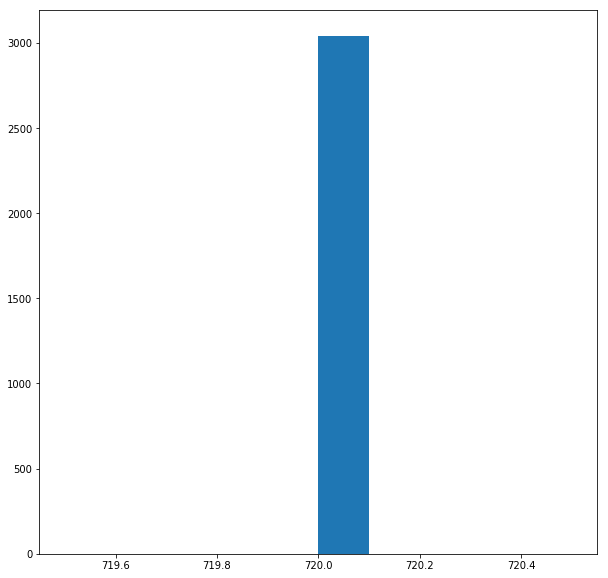

In [26]:
plt.hist(col_sz);

(array([   0.,    0.,    0.,    0.,    0., 3040.,    0.,    0.,    0.,    0.]),
 array([719.5, 719.6, 719.7, 719.8, 719.9, 720. , 720.1, 720.2, 720.3, 720.4, 720.5]),
 <a list of 10 Patch objects>)

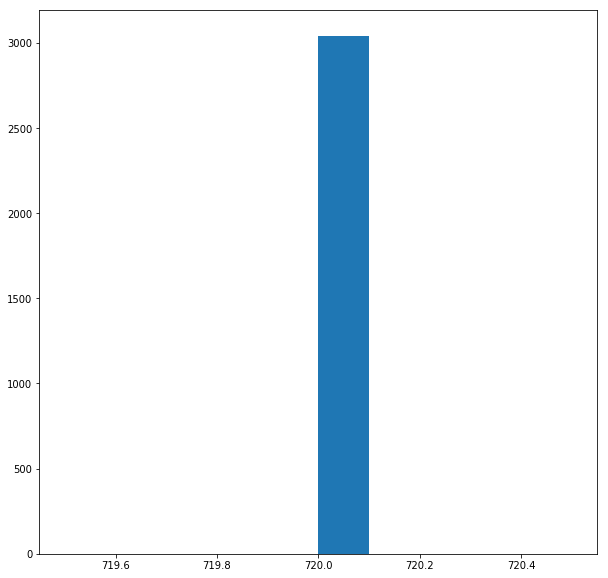

In [27]:
plt.hist(col_sz[col_sz < 1000])

In [28]:
len(data.trn_ds)#, len(data.test_ds)

3040

In [29]:
len(data.classes), data.classes[:5]

(11, ['class_0', 'class_1', 'class_10', 'class_2', 'class_3'])

## Initial model

In [30]:
def get_data(sz, bs): # sz: image size, bs: batch size
    tmfs = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'vidya/person', f'{PATH}y3.csv',
                                       val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
    
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/13
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/37
    return data if sz > 300 else data.resize(340, 'tmp') # Reading the jpgs and resizing is slow for big images, so resizing them all to 340 first saves time

#Source:   
#    def resize(self, targ, new_path):
#        new_ds = []
#        dls = [self.trn_dl,self.val_dl,self.fix_dl,self.aug_dl]
#        if self.test_dl: dls += [self.test_dl, self.test_aug_dl]
#        else: dls += [None,None]
#        t = tqdm_notebook(dls)
#        for dl in t: new_ds.append(self.resized(dl, targ, new_path))
#        t.close()
#        return self.__class__(new_ds[0].path, new_ds, self.bs, self.num_workers, self.classes)
#File:      ~/fastai/courses/dl1/fastai/dataset.py

In [31]:
data.trn_ds.get_y(10)

2

### Precompute

In [32]:
data = get_data(sz, bs)

['class_0', 'class_1', 'class_10', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9']
[2 2 2 ... 2 2 2]


In [33]:
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [34]:
#learn.lr_find()

In [35]:
#learn.sched.plot()

In [36]:
learn.fit(1e-2, cycle_len=5, n_cycle=1)

epoch      trn_loss   val_loss   accuracy                 
    0      2.698262   2.295586   0.176548  
    1      2.532158   2.243724   0.198946                 
    2      2.435391   2.250527   0.205534                 
    3      2.382987   2.229677   0.185771                 
    4      2.35582    2.231612   0.188406                 



[2.231612467326037, 0.18840580041936264]

In [37]:
data.val_ds.is_multi

False

In [38]:
preds = learn.predict_array(data.val_ds)

NotImplementedError: object

In [ ]:
preds = preds[:, 1:]

In [ ]:
ys = data.val_ds.y[:, 1:]; ys.shape

In [ ]:
preds

In [ ]:
np.argmax(ys, axis=1)

In [ ]:
np.argmax(preds, axis=1)

In [ ]:
plt.plot(preds)

In [ ]:
preds.shape

In [ ]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [ ]:
#plt.plot(np.stack([moving_average(x, n=25) for x in preds.transpose()]).transpose())
plt.plot(preds)
plt.plot(data.val_ds.y)
plt.show()

In [ ]:
ys = np.where(data.val_ds.y)[1]

In [ ]:
data.trn_ds.y[4]

In [ ]:
np.where(data.trn_ds.y[:1000, 0])

In [ ]:
data.val_ds.y.shape

In [ ]:
np.where(ys == 0)